In [1]:
from quadriga import QuadrigaClient
import crycompare
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import time
import math
from keras.models import Model, load_model, Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, BatchNormalization, Reshape
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt2
from tqdm import tqdm
import pickle
from scipy.signal import argrelextrema
import time
import os


Using TensorFlow backend.


In [2]:
client = QuadrigaClient(
    api_key='abc',
    api_secret='abc',
    client_id='0000',
    default_book='eth_btc'
)

## Helper Functions

In [3]:
def get_hist(dataLoop = -1):
    hist = crycompare.History()

    res = hist.histoHour('ETH','BTC',e='QuadrigaCX', limit=2000)
    data = []
    data.extend(res['Data'])
    count = 0
    while True or dataLoop==-1:
        count+=1
        if count==dataLoop:
            break
        
        lasttime = res['TimeFrom']
        res = hist.histoHour('ETH','BTC',e='QuadrigaCX', limit=2000, toTs=res['TimeFrom'])
        if len(res['Data']):
            data = res['Data'][:-1] + data
        else:
            break

    empty = []
    for i,x in enumerate(data):
        s = 0
        for y in x:
            if not y=='time': s += x[y]
        if s==0:
            empty.append(i)
        else:
            x['time'] = str(datetime.datetime.fromtimestamp(x['time']))

    for x in reversed(empty):
        data.pop(x)

    df = json_normalize(data)

    col_list = df.columns.tolist()
    col_list.remove('time')
    df = df[col_list]
    
    return df

def get_hist_timestamp(string=True):
    hist = crycompare.History()
    res = hist.histoHour('ETH','BTC',e='QuadrigaCX', limit=1)
    if string:
        res = str(datetime.datetime.fromtimestamp(res['TimeTo']))
    else:
        res = int(res['TimeTo'])
    return res

def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
        
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test, preprocessor

class Scaler():
    def __init__(self, a, b):
        self.amin = None
        self.bmin = None
        self.scale = None
        self.fit(a,b)

    def fit(self, a, b):
        self.amin = np.min(a)
        self.bmin = np.min(b)
        self.scale = (np.max(b) - np.min(b))/(np.max(a) - np.min(a))

    def transform(self, a):
        return (a - self.amin) * self.scale + self.bmin

def preprocess_data(dforig, seq_len, res_len, avg):
    df = pd.rolling_mean(dforig, avg).dropna().reset_index(drop=True)

    amount_of_features = len(df.columns)
    data = df.as_matrix()
    
    sequence_length = seq_len + res_len
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result, preprocessor = standard_scaler(train, result)
    
    X_train = train[:,:-res_len]
    y_train = train[:,-res_len:]
    X_test = result[int(row):,:-res_len]
    y_test = result[int(row):,-res_len:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

    #SCALER
    y_t = np.append(y_train, y_test, axis=0)
    samples = y_t.shape[0]

    a = y_t[:,0,:4]
    b = dforig.as_matrix()[seq_len:seq_len+samples,:4]
    scaler = Scaler(a,b)

    return [X_train, y_train, X_test, y_test], preprocessor, scaler

def process(seq_len, res_len, processor, avg):
    df = get_hist(1)
    df = pd.rolling_mean(df, avg).dropna().reset_index(drop=True)
    data = df.as_matrix()
    
    sequence_length = seq_len + res_len
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    
    # PREPROCESSOR
    test_samples, test_nx, test_ny = result.shape
    
    result = result.reshape((test_samples, test_nx * test_ny))
    result = preprocessor.transform(result)
    result = result.reshape((test_samples, test_nx, test_ny))
    # END PREPROCESSOR
    
    result = result[:,-seq_len:,:]
    return result

def future(model, s, window, forward=None):
    if forward==None: forward=window
    x_t = s.copy()
    fset = []
    for _ in xrange(forward):
        tmp = x_t[:,-window:,:]
        pred = model.predict(x_t[:,-window:,:])
        pred = np.expand_dims(pred, axis=1)
        x_t = np.append(x_t, pred, axis=1)
        fset.append(x_t[:,-(window+1):,:].tolist())
    return np.array(fset)


In [7]:
df = get_hist()
window = 48

(X_train, y_train, X_test, y_test), preprocessor, scaler = preprocess_data(df, window, 1, 24)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


('X_train', (11142, 48, 6))
('y_train', (11142, 1, 6))
('X_test', (1238, 48, 6))
('y_test', (1238, 1, 6))


/home/tommy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()


## Modelling / Training

In [5]:

def build_model(layers):
    reg = 0.001
    l = Input(layers[0])
    x = LSTM(layers[1], return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=l2(reg))(l)
    x = Dropout(0.3)(x)
    x = LSTM(layers[2], return_sequences=False, kernel_initializer='he_normal', kernel_regularizer=l2(reg))(x)    
    x = Dropout(0.4)(x)
    
    size = layers[3]
    x = Dense(output_dim=size[0]*size[1], kernel_initializer='he_normal', kernel_regularizer=l2(reg))(x)
    x = Activation("linear")(x)
    
    model = Model(l,x) 
    start = time.time()

    model.compile(loss="mse", optimizer='nadam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


model = load_model('model-48.h5')

In [6]:
model = load_model('model-48v2.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
model = build_model([X_train[0].shape, window, int(window*1), y_train[0].shape])

filepath = "weights-stock-{}v2.best.hdf5".format(window)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lr_reducer = ReduceLROnPlateau(factor=0.1, monitor='val_loss', cooldown=0, epsilon = 1e-04, patience=20, min_lr=0.5e-4, verbose=1)
early = EarlyStopping(monitor='val_acc', patience=40, verbose=1, mode='auto')

model.fit(
    X_train,
    np.reshape(y_train, (y_train.shape[0], y_train.shape[1]*y_train.shape[2])),
    batch_size=128,
    epochs=60,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint, lr_reducer, early])
model.save('model-{}v2.h5'.format(window))

## Visualization

In [12]:
avgd = process(window, 1, preprocessor, 24) 
avgd_out = future(model, avgd, window)
not_avgd = process(window, 1, preprocessor, 1)
not_avgd_out = future(model, not_avgd, window)

/home/tommy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:118: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()
/home/tommy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:118: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=1,center=False).mean()


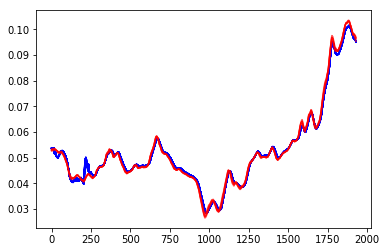

In [19]:
for x in xrange(48):
    curr = avgd_out[0,:,-1,:4]
    alp = (not_avgd_out.shape[0]-x+1)/float(not_avgd_out.shape[0]+1)/(2*x+1)
    plt2.plot(scaler.transform(curr), color='b', alpha=alp)
real = avgd[:,-1,:4]
plt2.plot(scaler.transform(real), color='r', alpha=0.7)
plt2.show()

## Test Trading (Not fully accurate)

In [ ]:
class TestTrader():
    def __init__(self, btc=0.66, eth=0):
        self.btc = float(btc)
        self.eth = float(eth)
        
        self.previous_traded_val = None
        self.desired_currency = None
        self.tracker = 0

    def test(self, out, out1, scaler):
        for i in xrange(out.shape[1]):
            curr_val = scaler.transform(np.mean(out1[0,i,-2,:4], axis=0))
            curr_val2 = scaler.transform(np.mean(out[0,i,-2,:4], axis=0))
            preds = scaler.transform(np.mean(out[:,i,-1,:4], axis=1))

#             preds = np.insert(preds,0,curr_val)
            diff = np.diff(preds)
            firstdiff = diff[0]
            CONV = 0.998*0.998
            
            print i
            print "curr_val_real",curr_val
            print "curr_val_avg",curr_val2
            
            peak_indices = argrelextrema(preds, np.greater)[0]
            trough_indices = argrelextrema(preds, np.less)[0]
            last_index = preds.shape[0]-1
            
            first_peak_index = np.append(peak_indices, last_index)[0]
            first_trough_index = np.append(trough_indices, last_index)[0]
            peak = preds[first_peak_index]
            trough = preds[first_trough_index]
            val=3

            print 'tracker', self.tracker
            if firstdiff>0:
                if self.desired_currency=='ETH':
                    self.tracker+=1
                else:
                    self.tracker=0
                        
                self.desired_currency = 'ETH'
                if first_peak_index<=first_trough_index:
                    if self.previous_traded_val:
                        print 'peak ind:{}'.format(first_peak_index)
                        print 'peak :{}'.format(peak)
                        print 'limit:{}'.format(self.previous_traded_val/CONV)
                        print 'trough ind:{}'.format(first_trough_index)
                        print 'trough:{}'.format(trough)
                    if self.previous_traded_val==None or peak>self.previous_traded_val/CONV or self.tracker>=val:
                        if self.btc!=0:
                            self.eth = self.btc/curr_val*0.998
                            self.btc = 0.
                            self.previous_traded_val = curr_val
            elif firstdiff<0:
                if self.desired_currency=='BTC':
                    self.tracker+=1
                else:
                    self.tracker=0
                self.desired_currency = 'BTC'
                if first_trough_index<=first_peak_index:
                    if self.previous_traded_val:
                        print 'trough ind:{}'.format(first_trough_index)
                        print 'trough:{}'.format(trough)
                        print 'limit :{}'.format(self.previous_traded_val*CONV)
                        print 'peak ind:{}'.format(first_peak_index)
                        print 'peak :{}'.format(peak)
                    
                    if self.previous_traded_val==None or trough<self.previous_traded_val*CONV or self.tracker>=val:
                        if self.eth!=0:
                            self.btc = self.eth*curr_val*0.998
                            self.eth = 0.
                            self.previous_traded_val = curr_val
            print self.desired_currency
            print self.get_fund()
            print self.previous_traded_val
            plt2.plot(preds)
            plt2.show()
            print
                        
    def get_fund(self):
        return [self.btc, self.eth]

tester = TestTrader()
tester.test(out, out1, scaler)
tester.get_fund()

In [ ]:
av = process(window, 1, preprocessor, 24)
avf = future(model, av[-1:,:,:], window)
real = process(window, 1, preprocessor, 1)
realf = future(model, real[-1:,:,:], window)

tester1 = TestTrader()
tester1.test(avf, realf, scaler)
tester1.get_fund()

## Actual Trader (Needs more work: API Limits)

In [ ]:
class Trader():
    def __init__(self, client):
        self.client = client
        self.wait_time = 2
        self.pickle = 'arr.pickle'
        
        self.tracker = 0
        trades = self.client.get_trades()
        self.desired_currency = 'BTC' if float(trades[0]['btc'])>0 else 'ETH'
        self.previous_traded_val = float(trades[0]['rate'])
        self.last_time = None
        self.traded=False
        
        if os.path.isfile(self.pickle):
            with open (self.pickle, 'rb') as fp:
                arr = pickle.load(fp)
        
            self.tracker = arr[0]
            self.desired_currency = arr[1]
            self.previous_traded_val = arr[2]
            self.last_time = arr[3]
                
    def save(self):
        arr = [self.tracker, self.desired_currency, self.previous_traded_val, self.last_time]
        with open(self.pickle,'wb') as fp:
            pickle.dump(arr, fp)
            
    def get_trades(self, available):
        orig_avail = available
        time.sleep(self.wait_time)
        public_orders = self.client.get_public_orders()
        orders = []

        if self.desired_currency=='ETH': l = public_orders['asks'] #when desired curr is ETH
        elif self.desired_currency=='BTC': l = public_orders['bids'] #when desired curr is BTC

        for price, amount_eth in l:
            price = float(price)
            amount_eth = float(amount_eth)
            if self.desired_currency=='ETH': available_eth = available/price
            elif self.desired_currency=='BTC': available_eth = available

            if amount_eth<=available_eth:
#                 orders.append((price,amount_eth))
                if self.desired_currency=='ETH': available -= amount_eth*price
                elif self.desired_currency=='BTC': available -= amount_eth

            elif amount_eth>available_eth:
                avail = 0
                if self.desired_currency=='ETH': avail = orig_avail/price
                elif self.desired_currency=='BTC': avail = orig_avail
                orders.append((price,avail))
                available=0

            if available==0:
                return orders   
            
    def get_funds(self):
        time.sleep(self.wait_time)
        funds = self.client.get_balance()
        btc = float(funds['btc_available'])
        eth = float(funds['eth_available'])
        return [btc, eth]

    def trade(self):
        if self.traded==True:
            return
        origfunds = self.get_funds()
        btc, eth = origfunds
        did_action = False
        while btc if self.desired_currency=='ETH' else eth != 0:
            did_action = True
            if self.desired_currency=='ETH':
                available = btc
            elif self.desired_currency=='BTC':
                available = eth
            orders = self.get_trades(available)
            print 'orders:', orders
            try:
                for price, amount in orders:
                    if self.desired_currency=='ETH':
                        self.client.buy_limit_order(amount, price)
                    elif self.desired_currency=='BTC':
                        self.client.sell_limit_order(amount, price)
            except Exception as e:
                print e
                print 'error'
                time.sleep(10)
            btc, eth = self.get_funds()
        
        nowfunds = [btc, eth]
        if (self.desired_currency=='BTC' and eth==0) or (self.desired_currency=='ETH' and btc==0):
            self.traded=True
        print 'self.traded', self.traded
        print nowfunds
        if did_action:
            if self.desired_currency=='ETH':
                self.previous_traded_val = float(sum(origfunds))/sum(nowfunds)
            else:
                self.previous_traded_val = float(sum(nowfunds))/sum(origfunds)
        
    def exe(self, model, window, preprocessor, scaler):
        timestamp = get_hist_timestamp(False)
        if self.last_time==timestamp: 
            return
        self.last_time = timestamp
        
        result = process(window, 1, preprocessor, 24)
        out = future(model, result[-1:,:,:], window)
        result_1 = process(window, 1, preprocessor, 1)
        print result_1.shape
        
        curr_val = scaler.transform(np.mean(result_1[-1,-1,:4], axis=0))
        preds = scaler.transform(np.mean(out[:,0,-1,:4], axis=1))
        diff = np.diff(preds)
        firstdiff = diff[0]
        CONV = 0.998*0.998

        print 'curr_val:', curr_val

        peak_indices = argrelextrema(preds, np.greater)[0]
        trough_indices = argrelextrema(preds, np.less)[0]
        last_index = preds.shape[0]-1

        first_peak_index = np.append(peak_indices, last_index)[0]
        first_trough_index = np.append(trough_indices, last_index)[0]
        peak = preds[first_peak_index]
        trough = preds[first_trough_index]
        tracker_val = 3
        
        print 'tracker:', self.tracker
        if firstdiff>0:
            if self.desired_currency=='ETH':
                self.tracker+=1
            else:
                self.tracker=0
                self.traded=False

            self.desired_currency = 'ETH'
            if first_peak_index<=first_trough_index:
                limit = self.previous_traded_val/CONV
                if self.previous_traded_val:
                    print 'prev: {}'.format(self.previous_traded_val)
                    print 'peak ind:{}'.format(first_peak_index)
                    print 'peak :{}'.format(peak)
                    print 'limit:{}'.format(limit)
                    print 'trough ind:{}'.format(first_trough_index)
                    print 'trough:{}'.format(trough)
                if not self.traded:
                    if self.previous_traded_val==None or peak>limit and self.tracker<tracker_val or self.tracker>=tracker_val:
                        print 'here'
                        self.trade()
        elif firstdiff<0:
            if self.desired_currency=='BTC':
                self.tracker+=1
            else:
                self.tracker=0
                self.traded=False
            self.desired_currency = 'BTC'
            if first_trough_index<=first_peak_index:
                limit = self.previous_traded_val*CONV
                if self.previous_traded_val:
                    print 'prev: {}'.format(self.previous_traded_val)
                    print 'trough ind:{}'.format(first_trough_index)
                    print 'trough:{}'.format(trough)
                    print 'limit :{}'.format(limit)
                    print 'peak ind:{}'.format(first_peak_index)
                    print 'peak :{}'.format(peak)
                if not self.traded:
                    if self.previous_traded_val==None or trough<limit and self.tracker<tracker_val or self.tracker>=tracker_val:
                        print 'there'
                        self.trade()
        
#         print 'funds:', self.get_funds()
        print 'prev: {}'.format(self.previous_traded_val)

        print 'desired_currency:', self.desired_currency
        print

In [ ]:
starttime=time.time()
time_freq = 20*60.0
while True:
    trader.exe(model, window, preprocessor, scaler)
    time.sleep(time_freq - ((time.time() - starttime) % time_freq))